### **Life Expectancy Analysis Based on Sustainable Development Goals (SDGs)**

### **Author: Michael Moore**


# Global constants

In [ ]:
JAVA_HOME = "/usr/lib/jvm/java-8-openjdk-amd64"
GDRIVE_DIR = "/content/gdrive"
GDRIVE_HOME_DIR = GDRIVE_DIR + "/My Drive"
RANDOM_SEED = 42 # for reproducibility

# **Spark + Google Colab Setup**

## **1.** Install PySpark and related dependencies

In [ ]:
!pip install pyspark
!pip install -U -q PyDrive
!apt install openjdk-8-jdk-headless -qq
import os
os.environ["JAVA_HOME"] = JAVA_HOME

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 4.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.4.0-py2.py3-none-any.whl size=311317130 sha256=f70965ad75c6ca7cea4d935571c4c6a1b25d7a274e70d82b76062f9fc6f69365
  Stored in directory: /root/.cache/pip/wheels/7b/1b/4b/3363a1d04368e7ff0d408e57ff57966fcdf00583774e761327
Successfully built pyspark
The following additional packages will be installed:
  libxtst6 openjdk-8-jre-headless
Suggested packages:
  openjdk-8-demo openjdk-8-source libnss-mdns fonts-dejavu-extra
  fonts-ipafont-gothic fonts-ipafont-mincho fonts-wqy-microhei
  fonts-wqy-zenhei fonts-indic
The following NEW packages will be installed:
  libxtst6 openjdk-8-jdk-headless openjdk-8-jre-headless
0 upgraded, 3 newly installed, 0 to remove and 34 not upgraded.
Need to get 36.5 MB of archives.
After this operatio

## **2.** Import useful Python packages

In [ ]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import pyspark
from pyspark.sql import *
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark import SparkContext, SparkConf

## **3.** Create Spark context

In [ ]:
# create the session
conf = SparkConf().set("spark.ui.port", "4050").set('spark.executor.memory', '4G').set('spark.driver.memory', '45G').set('spark.driver.maxResultSize', '10G')

# create the context
sc = pyspark.SparkContext(conf=conf)
spark = SparkSession.builder.getOrCreate()

## **4.** Link Colab to our Google Drive

In [ ]:
# Point Colaboratory to our Google Drive

from google.colab import drive

drive.mount(GDRIVE_DIR, force_remount=True)

Mounted at /content/gdrive


## **5.** Check everything is ok

In [ ]:
spark

In [ ]:
sc._conf.getAll()

[('spark.driver.memory', '45G'),
 ('spark.executor.id', 'driver'),
 ('spark.sql.warehouse.dir', 'file:/content/spark-warehouse'),
 ('spark.driver.maxResultSize', '10G'),
 ('spark.app.startTime', '1685394309248'),
 ('spark.app.name', 'pyspark-shell'),
 ('spark.driver.extraJavaOptions',
  '-Djava.net.preferIPv6Addresses=false -XX:+IgnoreUnrecognizedVMOptions --add-opens=java.base/java.lang=ALL-UNNAMED --add-opens=java.base/java.lang.invoke=ALL-UNNAMED --add-opens=java.base/java.lang.reflect=ALL-UNNAMED --add-opens=java.base/java.io=ALL-UNNAMED --add-opens=java.base/java.net=ALL-UNNAMED --add-opens=java.base/java.nio=ALL-UNNAMED --add-opens=java.base/java.util=ALL-UNNAMED --add-opens=java.base/java.util.concurrent=ALL-UNNAMED --add-opens=java.base/java.util.concurrent.atomic=ALL-UNNAMED --add-opens=java.base/sun.nio.ch=ALL-UNNAMED --add-opens=java.base/sun.nio.cs=ALL-UNNAMED --add-opens=java.base/sun.security.action=ALL-UNNAMED --add-opens=java.base/sun.util.calendar=ALL-UNNAMED --add-ope

# **The Prediction Task**

# **1. Data Collection**

The filtered dataset was downloaded from the World Development Indicators DataBank found at data.worldbank.org. This dataset was stored as a CSV file in the "My Drive" folder of the Google Drive and the code below loads the data into a Spark dataframe.

### **Please place the attached CSV file in the "My Drive" folder of the "gdrive"**

In [ ]:
SDG_df = spark.read.load("/content/gdrive/My Drive/Assignment_2_Data_File.csv",
                         format="csv",
                         sep=",",
                         inferSchema="true",
                         header="true"
                         )

### **Shape of the loaded dataset**

In [ ]:
print("The shape of the dataset is {:d} rows by {:d} columns".format(SDG_df.count(), len(SDG_df.columns)))

The shape of the dataset is 2317 rows by 23 columns


### **Schema of the loaded dataset**

In [ ]:
SDG_df.printSchema()

root
 |-- Time: string (nullable = true)
 |-- Time Code: string (nullable = true)
 |-- Country Name: string (nullable = true)
 |-- Country Code: string (nullable = true)
 |-- Access to electricity (% of population) [EG.ELC.ACCS.ZS]: string (nullable = true)
 |-- GNI per capita, PPP (current international $) [NY.GNP.PCAP.PP.CD]: string (nullable = true)
 |-- Prevalence of undernourishment (% of population) [SN.ITK.DEFC.ZS]: string (nullable = true)
 |-- Food production index (2014-2016 = 100) [AG.PRD.FOOD.XD]: string (nullable = true)
 |-- Prevalence of HIV, total (% of population ages 15-49) [SH.DYN.AIDS.ZS]: string (nullable = true)
 |-- Fertility rate, total (births per woman) [SP.DYN.TFRT.IN]: string (nullable = true)
 |-- School enrollment, primary (% net) [SE.PRM.NENR]: string (nullable = true)
 |-- School enrollment, secondary (% net) [SE.SEC.NENR]: string (nullable = true)
 |-- Labor force participation rate, female (% of female population ages 15+) (national estimate) [SL.TLF.C

### **Description of dataset**

The dataset contains **2317** records, and each record contains the following **23** columns:

- `Time`: Year in which the data was collected (_numerical_, _discrete_);
- `Time Code`: Code used to represent the year in which the data was collected (_categorical_, _nominal_);
- `Country Name`: Name of the country from which the data was collected (_categorical_, _nominal_);
- `Country Code`: Code used to represent the country from which the data was collected (_categorical_, _nominal_);
- `Access to electricity (% of population)`: Percentage of the population in a specific country that has access to electricity (_numerical_, _continuous_);
- `GNI per capita, PPP (current international $)`: Total amount of money earned by the people of a specific country over a year (_numerical_, _continuous_);
- `Prevalence of undernourishment (% of population)`: Percentage of the population of a specific country that has a lack of access to food for good health and condition (_numerical_, _continuous_);
- `Food production index (2014-2016 = 100)`: Measure of the change in food production in a specific country from 2014 to 2016 (_numerical_, _continuous_);
- `Prevalence of HIV, total (% of population ages 15-49)`: Percentage of the population aged 15-49 that have been diagnosed with HIV in a specific country (_numerical_, _continuous_);
- `Fertility rate, total (births per woman)`: The number of births per woman in a specific country (_numerical_, _discrete_);
- `School enrollment, primary (% net)`: Percentage of primary school-aged children enrolled in primary school in a specific country (_numerical_, _continuous_);
- `School enrollment, secondary (% net)`: Percentage of secondary school-aged children enrolled in secondary school in a specific country (_numerical_, _continuous_);
- `Labor force participation rate, female (% of female population ages 15+)`: Percentage of females aged 15+ that are actively employed in a specific country (_numerical_, _continuous_);
- `Proportion of seats held by women in national parliaments (%)`: Percentage of the seats in parliment that are held by woman in a specific country (_numerical_, _continuous_);
- `People using at least basic drinking water services (% of population)`: Percentage of the population of a specific country that have access to basic drinking water services (_numerical_, _continuous_);
- `Unemployment with basic education (% of total labor force with basic education)`: Percentage of the population of a specific country that obtained a basic education but remain unemployed (_numerical_, _continuous_);
- `Urban population (% of total population)`: Percentage of the population of a specific country that live in urban areas (_numerical_, _continuous_);
- `Population living in slums (% of urban population)`: Percentage of the urban population of a country that live in slums (_numerical_, _continuous_);
- `Population density (people per sq. km of land area)`: The number of people per square kilometre of land in a specific country (_numerical_, _continuous_);
- `CO2 emissions (metric tons per capita)`: Amount of CO2 released per capita in a specific country over a year (_numerical_, _continuous_);
- `Forest area (% of land area)`: Percentage of land in a specific country that is covered by forests (_numerical_, _continuous_);
- `Military expenditure (% of GDP)`: Percentage of a specific country's GDP that is spent on military related expenses (_numerical_, _continuous_);
- **`Life expectancy at birth, total (years)`**: The life expectancy of an individual in a specific country (_numerical_, _continuous_); **[This is the _target_ variable to be predicted]**



### **Change Column Names**

The original column names contained a code at the end which caused errors due to its format and thus this code has been removed from each column name.

In [ ]:
SDG_df = SDG_df.withColumnRenamed("Access to electricity (% of population) [EG.ELC.ACCS.ZS]", "Access to electricity (% of population)")
SDG_df = SDG_df.withColumnRenamed("GNI per capita, PPP (current international $) [NY.GNP.PCAP.PP.CD]", "GNI per capita, PPP (current international $)")
SDG_df = SDG_df.withColumnRenamed("Prevalence of undernourishment (% of population) [SN.ITK.DEFC.ZS]", "Prevalence of undernourishment (% of population)")
SDG_df = SDG_df.withColumnRenamed("Food production index (2014-2016 = 100) [AG.PRD.FOOD.XD]", "Food production index (2014-2016 = 100)")
SDG_df = SDG_df.withColumnRenamed("Prevalence of HIV, total (% of population ages 15-49) [SH.DYN.AIDS.ZS]", "Prevalence of HIV, total (% of population ages 15-49)")
SDG_df = SDG_df.withColumnRenamed("Fertility rate, total (births per woman) [SP.DYN.TFRT.IN]", "Fertility rate, total (births per woman)")
SDG_df = SDG_df.withColumnRenamed("School enrollment, primary (% net) [SE.PRM.NENR]", "School enrollment, primary (% net)")
SDG_df = SDG_df.withColumnRenamed("School enrollment, secondary (% net) [SE.SEC.NENR]", "School enrollment, secondary (% net)")
SDG_df = SDG_df.withColumnRenamed("Labor force participation rate, female (% of female population ages 15+) (national estimate) [SL.TLF.CACT.FE.NE.ZS]", "Labor force participation rate, female (% of female population ages 15+) (national estimate)")
SDG_df = SDG_df.withColumnRenamed("Proportion of seats held by women in national parliaments (%) [SG.GEN.PARL.ZS]", "Proportion of seats held by women in national parliaments (%)")
SDG_df = SDG_df.withColumnRenamed("People using at least basic drinking water services (% of population) [SH.H2O.BASW.ZS]", "People using at least basic drinking water services (% of population)")
SDG_df = SDG_df.withColumnRenamed("Unemployment with basic education (% of total labor force with basic education) [SL.UEM.BASC.ZS]", "Unemployment with basic education (% of total labor force with basic education)")
SDG_df = SDG_df.withColumnRenamed("Urban population (% of total population) [SP.URB.TOTL.IN.ZS]", "Urban population (% of total population)")
SDG_df = SDG_df.withColumnRenamed("Population living in slums (% of urban population) [EN.POP.SLUM.UR.ZS]", "Population living in slums (% of urban population)")
SDG_df = SDG_df.withColumnRenamed("Population density (people per sq. km of land area) [EN.POP.DNST]", "Population density (people per sq km of land area)")
SDG_df = SDG_df.withColumnRenamed("CO2 emissions (metric tons per capita) [EN.ATM.CO2E.PC]", "CO2 emissions (metric tons per capita)")
SDG_df = SDG_df.withColumnRenamed("Forest area (% of land area) [AG.LND.FRST.ZS]", "Forest area (% of land area)")
SDG_df = SDG_df.withColumnRenamed("Military expenditure (% of GDP) [MS.MIL.XPND.GD.ZS]", "Military expenditure (% of GDP)")
SDG_df = SDG_df.withColumnRenamed("Life expectancy at birth, total (years) [SP.DYN.LE00.IN]", "Life expectancy at birth, total (years)")

### **Display the first 5 rows of the dataset**

In [ ]:
SDG_df.show(5)

+----+---------+--------------+------------+---------------------------------------+---------------------------------------------+------------------------------------------------+---------------------------------------+-----------------------------------------------------+----------------------------------------+----------------------------------+------------------------------------+--------------------------------------------------------------------------------------------+-------------------------------------------------------------+---------------------------------------------------------------------+-------------------------------------------------------------------------------+----------------------------------------+--------------------------------------------------+--------------------------------------------------+--------------------------------------+----------------------------+-------------------------------+---------------------------------------+
|Time|Time Code|  Country

# **2. Data Preprocessing**

The dataset has missing values which have been represented using ".." or "...". The dataset also contains empty rows and thus the code below handles this missing data.

### **Check for empty rows**

In [ ]:
for c in SDG_df.columns:
  print("N. of empty rows of column `{:s}` = {:d}".format(c, SDG_df.where(col(c).isNull()).count()))

N. of empty rows of column `Time` = 3
N. of empty rows of column `Time Code` = 5
N. of empty rows of column `Country Name` = 5
N. of empty rows of column `Country Code` = 5
N. of empty rows of column `Access to electricity (% of population)` = 5
N. of empty rows of column `GNI per capita, PPP (current international $)` = 5
N. of empty rows of column `Prevalence of undernourishment (% of population)` = 5
N. of empty rows of column `Food production index (2014-2016 = 100)` = 5
N. of empty rows of column `Prevalence of HIV, total (% of population ages 15-49)` = 5
N. of empty rows of column `Fertility rate, total (births per woman)` = 5
N. of empty rows of column `School enrollment, primary (% net)` = 5
N. of empty rows of column `School enrollment, secondary (% net)` = 5
N. of empty rows of column `Labor force participation rate, female (% of female population ages 15+) (national estimate)` = 5
N. of empty rows of column `Proportion of seats held by women in national parliaments (%)` = 5


### **Determine which rows are empty**

In [ ]:
pandas_df = SDG_df.toPandas()
rows_with_missing_values = pandas_df[pandas_df.isnull().any(axis=1)]
print(rows_with_missing_values)

                                                  Time Time Code Country Name  \
2312                                              None      None         None   
2313                                              None      None         None   
2314                                              None      None         None   
2315  Data from database: World Development Indicators      None         None   
2316                          Last Updated: 05/10/2023      None         None   

     Country Code Access to electricity (% of population)  \
2312         None                                    None   
2313         None                                    None   
2314         None                                    None   
2315         None                                    None   
2316         None                                    None   

     GNI per capita, PPP (current international $)  \
2312                                          None   
2313                                  

### **Remove empty rows**

All the NULL values occur in the same five rows ranging from 2312 - 2316 and thus these rows have been removed from the dataset because they do not provide any meangiful data.

In [ ]:
SDG_df = SDG_df.na.drop(subset=["CO2 emissions (metric tons per capita)"])
print("The shape of the dataset is {:d} rows by {:d} columns".format(SDG_df.count(), len(SDG_df.columns)))

The shape of the dataset is 2312 rows by 23 columns


### **Check for missing values represented by ".." or "..."**

In [ ]:
import re
pattern = re.compile(r'^\.')

for col_name in SDG_df.columns:

    # Count the number of strings starting with a dot in each column
    count = SDG_df.select(col_name).rdd.flatMap(lambda row: pattern.findall(str(row[0]))).count()

    # Print the number of missing values for each column
    print(f"N. of missing values of column '{col_name}'= {count}")

N. of missing values of column 'Time'= 0
N. of missing values of column 'Time Code'= 0
N. of missing values of column 'Country Name'= 0
N. of missing values of column 'Country Code'= 0
N. of missing values of column 'Access to electricity (% of population)'= 52
N. of missing values of column 'GNI per capita, PPP (current international $)'= 137
N. of missing values of column 'Prevalence of undernourishment (% of population)'= 568
N. of missing values of column 'Food production index (2014-2016 = 100)'= 87
N. of missing values of column 'Prevalence of HIV, total (% of population ages 15-49)'= 476
N. of missing values of column 'Fertility rate, total (births per woman)'= 30
N. of missing values of column 'School enrollment, primary (% net)'= 913
N. of missing values of column 'School enrollment, secondary (% net)'= 1349
N. of missing values of column 'Labor force participation rate, female (% of female population ages 15+) (national estimate)'= 1289
N. of missing values of column 'Proport

### **Convert ".." or "..." entries to NULL**

In [ ]:
for col_name in SDG_df.columns:
    SDG_df = SDG_df.withColumn(col_name, when(col(col_name).startswith('.'), None).otherwise(col(col_name)))

### **Convert string entries to type float**

All the entries within the dataset are represented as strings which prevents the use of any numerical operations and thus the values have been converted to type float.

In [ ]:
for column in SDG_df.columns:
    SDG_df = SDG_df.withColumn(column, col(column).cast("float"))

### **Drop unnecessary columns**

This assignment is concerned with the relationship between the SDGs (Sustainable Development Goals) and life expectancy, and thus information regarding the year in which the data was collected or the country from which it was obtained is unnecessary and can be dropped from the dataset.

In [ ]:
columns_to_drop = ['Time', 'Time Code', 'Country Name', 'Country Code']
SDG_df = SDG_df.drop(*columns_to_drop)

### **Drop features missing more than 25% of their values**

Each feature is missing differing amounts of values and thus a threshold had to be set, beyond which the feature would be dropped. The threshold was set at 25% of missing values.  

In [ ]:
columns_to_drop = ['School enrollment, primary (% net)', 'Labor force participation rate, female (% of female population ages 15+) (national estimate)', 'Unemployment with basic education (% of total labor force with basic education)', 'Population living in slums (% of urban population)','School enrollment, secondary (% net)','Military expenditure (% of GDP)']
SDG_df = SDG_df.drop(*columns_to_drop)

### **Drop rows missing life expectancy data**

32 rows were missing data about the life expectancy and thus these were dropped because it is a relatively small percentage of the total dataset. It was also decided to not impute the mean values for life expectancy because it is the target variable and thus the accuracy of this variable is critical to the success of the model.

In [ ]:
SDG_df = SDG_df.na.drop(subset=["Life expectancy at birth, total (years)"])

### **Check the number of missing values after dropping features and rows**

In [ ]:
for c in SDG_df.columns:
  print("N. of missing values of column `{:s}` = {:d}".format(c, SDG_df.where(col(c).isNull()).count()))

N. of missing values of column `Access to electricity (% of population)` = 35
N. of missing values of column `GNI per capita, PPP (current international $)` = 120
N. of missing values of column `Prevalence of undernourishment (% of population)` = 536
N. of missing values of column `Food production index (2014-2016 = 100)` = 55
N. of missing values of column `Prevalence of HIV, total (% of population ages 15-49)` = 444
N. of missing values of column `Fertility rate, total (births per woman)` = 0
N. of missing values of column `Proportion of seats held by women in national parliaments (%)` = 178
N. of missing values of column `People using at least basic drinking water services (% of population)` = 38
N. of missing values of column `Urban population (% of total population)` = 17
N. of missing values of column `Population density (people per sq km of land area)` = 29
N. of missing values of column `CO2 emissions (metric tons per capita)` = 34
N. of missing values of column `Forest area (%

### **Impute the mean value of each column to fill the missing values**

To estimate the missing data, the mean of the feature from which the entry was missing was used. This method of imputation has the possibility of producing outliers; however, dropping the rows would be worse due to the small size of the dataset.

In [ ]:
for column in SDG_df.columns:
    mean_value = SDG_df.agg(mean(column)).collect()[0][0]
    SDG_df = SDG_df.fillna(mean_value, subset=[column])

### **Number of missing values after data preprocessing**

In [ ]:
for c in SDG_df.columns:
  print("N. of missing values of column `{:s}` = {:d}".format(c, SDG_df.where(col(c).isNull()).count()))

N. of missing values of column `Access to electricity (% of population)` = 0
N. of missing values of column `GNI per capita, PPP (current international $)` = 0
N. of missing values of column `Prevalence of undernourishment (% of population)` = 0
N. of missing values of column `Food production index (2014-2016 = 100)` = 0
N. of missing values of column `Prevalence of HIV, total (% of population ages 15-49)` = 0
N. of missing values of column `Fertility rate, total (births per woman)` = 0
N. of missing values of column `Proportion of seats held by women in national parliaments (%)` = 0
N. of missing values of column `People using at least basic drinking water services (% of population)` = 0
N. of missing values of column `Urban population (% of total population)` = 0
N. of missing values of column `Population density (people per sq km of land area)` = 0
N. of missing values of column `CO2 emissions (metric tons per capita)` = 0
N. of missing values of column `Forest area (% of land area)

# **3. Exploratory Data Analysis**

### **Summary of descriptive statistics**

The statistics of the different features have been presented below which allows for insight into the characteristics of the dataset. The Spark dataframe has also be converted to a Pandas dataframe to allow for the visualisation of the data.

In [ ]:
SDG_df.describe().show()

+-------+---------------------------------------+---------------------------------------------+------------------------------------------------+---------------------------------------+-----------------------------------------------------+----------------------------------------+-------------------------------------------------------------+---------------------------------------------------------------------+----------------------------------------+--------------------------------------------------+--------------------------------------+----------------------------+---------------------------------------+
|summary|Access to electricity (% of population)|GNI per capita, PPP (current international $)|Prevalence of undernourishment (% of population)|Food production index (2014-2016 = 100)|Prevalence of HIV, total (% of population ages 15-49)|Fertility rate, total (births per woman)|Proportion of seats held by women in national parliaments (%)|People using at least basic drinking water serv

In [ ]:
# Convert Spark Dataframe to Pandas Dataframe
SDG_pdf = SDG_df.toPandas()

In [ ]:
# Set default plotting configurations
sns.set_style("darkgrid")
sns.set_context("notebook", rc={"lines.linewidth": 2,
                                "xtick.labelsize":8,
                                "ytick.labelsize":8,
                                "axes.labelsize": 10
                                })

### **Distribution plots**

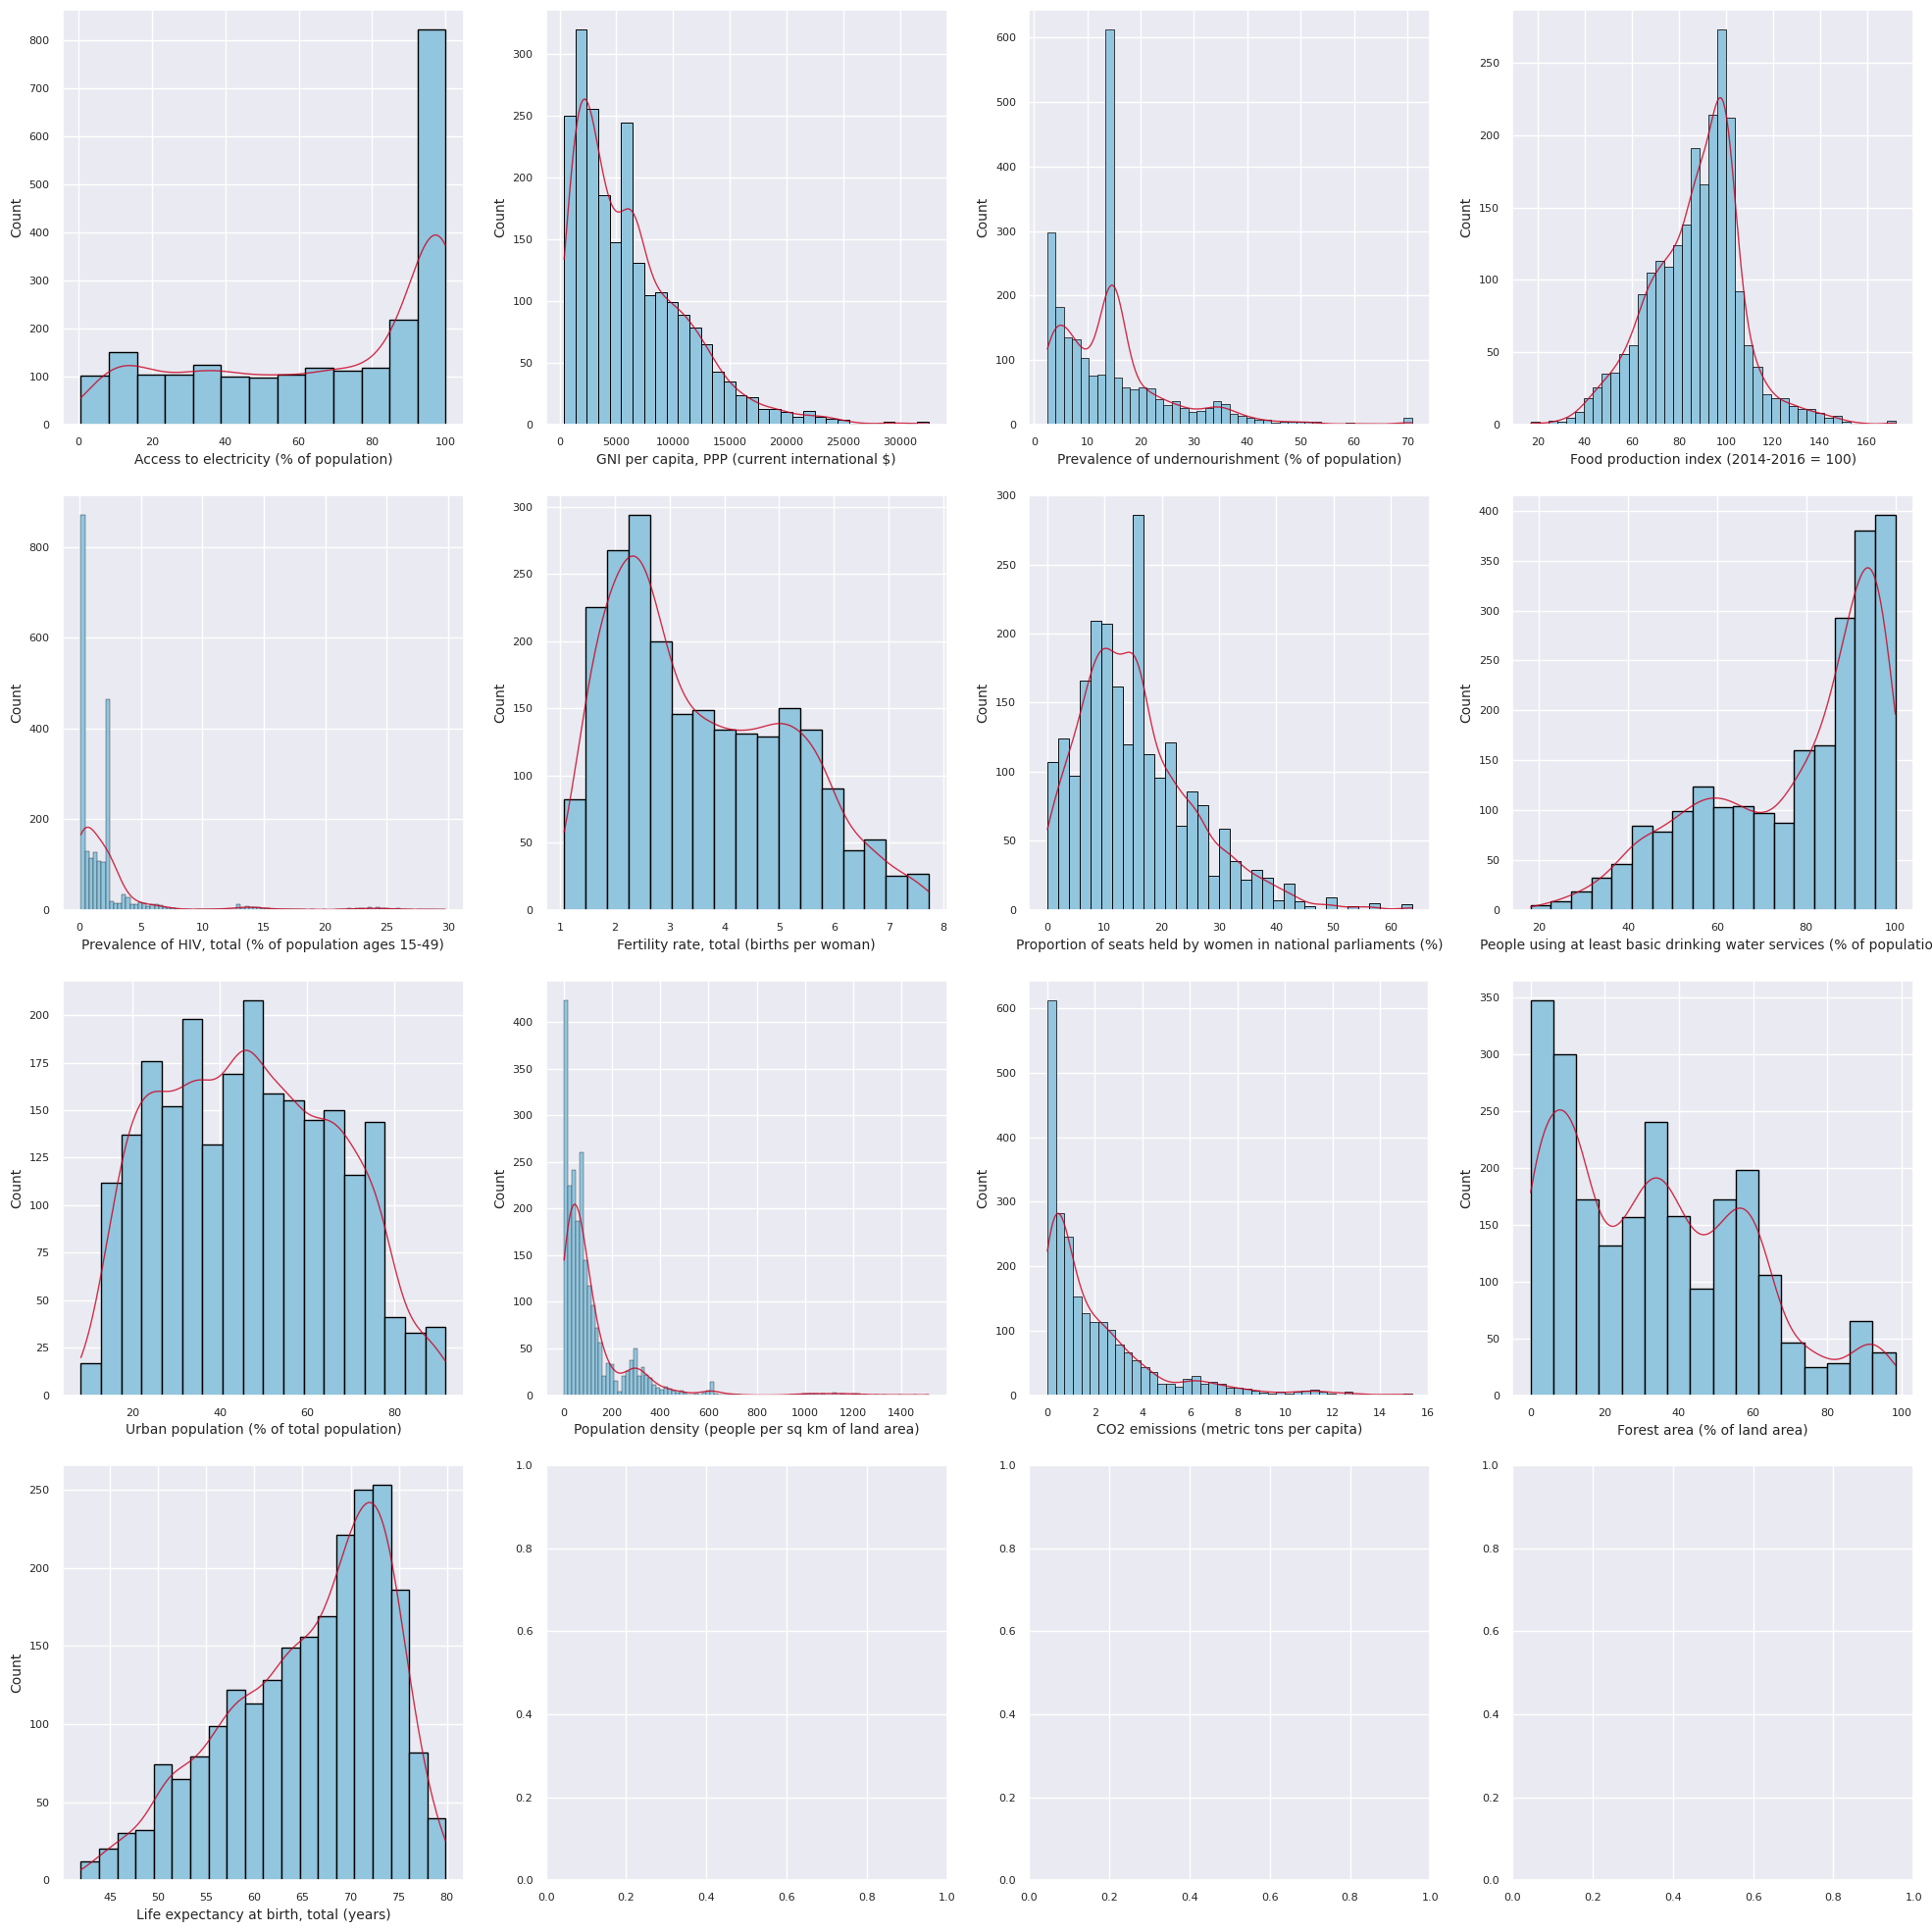

In [ ]:
# Plot the distribution of values of each column of interest
n_rows = 4
n_cols = 4

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20,20))

for i,f in enumerate(SDG_pdf.columns):

  _ = sns.histplot(SDG_pdf[f],
                  kde=True,
                  color="#ca0020",
                  line_kws={"linewidth": 1, "alpha": 0.8},
                  facecolor="#92c5de",
                  edgecolor="black",
                  ax=axes[i//n_cols, i%n_cols]
                  )

fig.tight_layout(pad=1.5)

### **Relationship between features and the target variable (`Life expectancy`)**

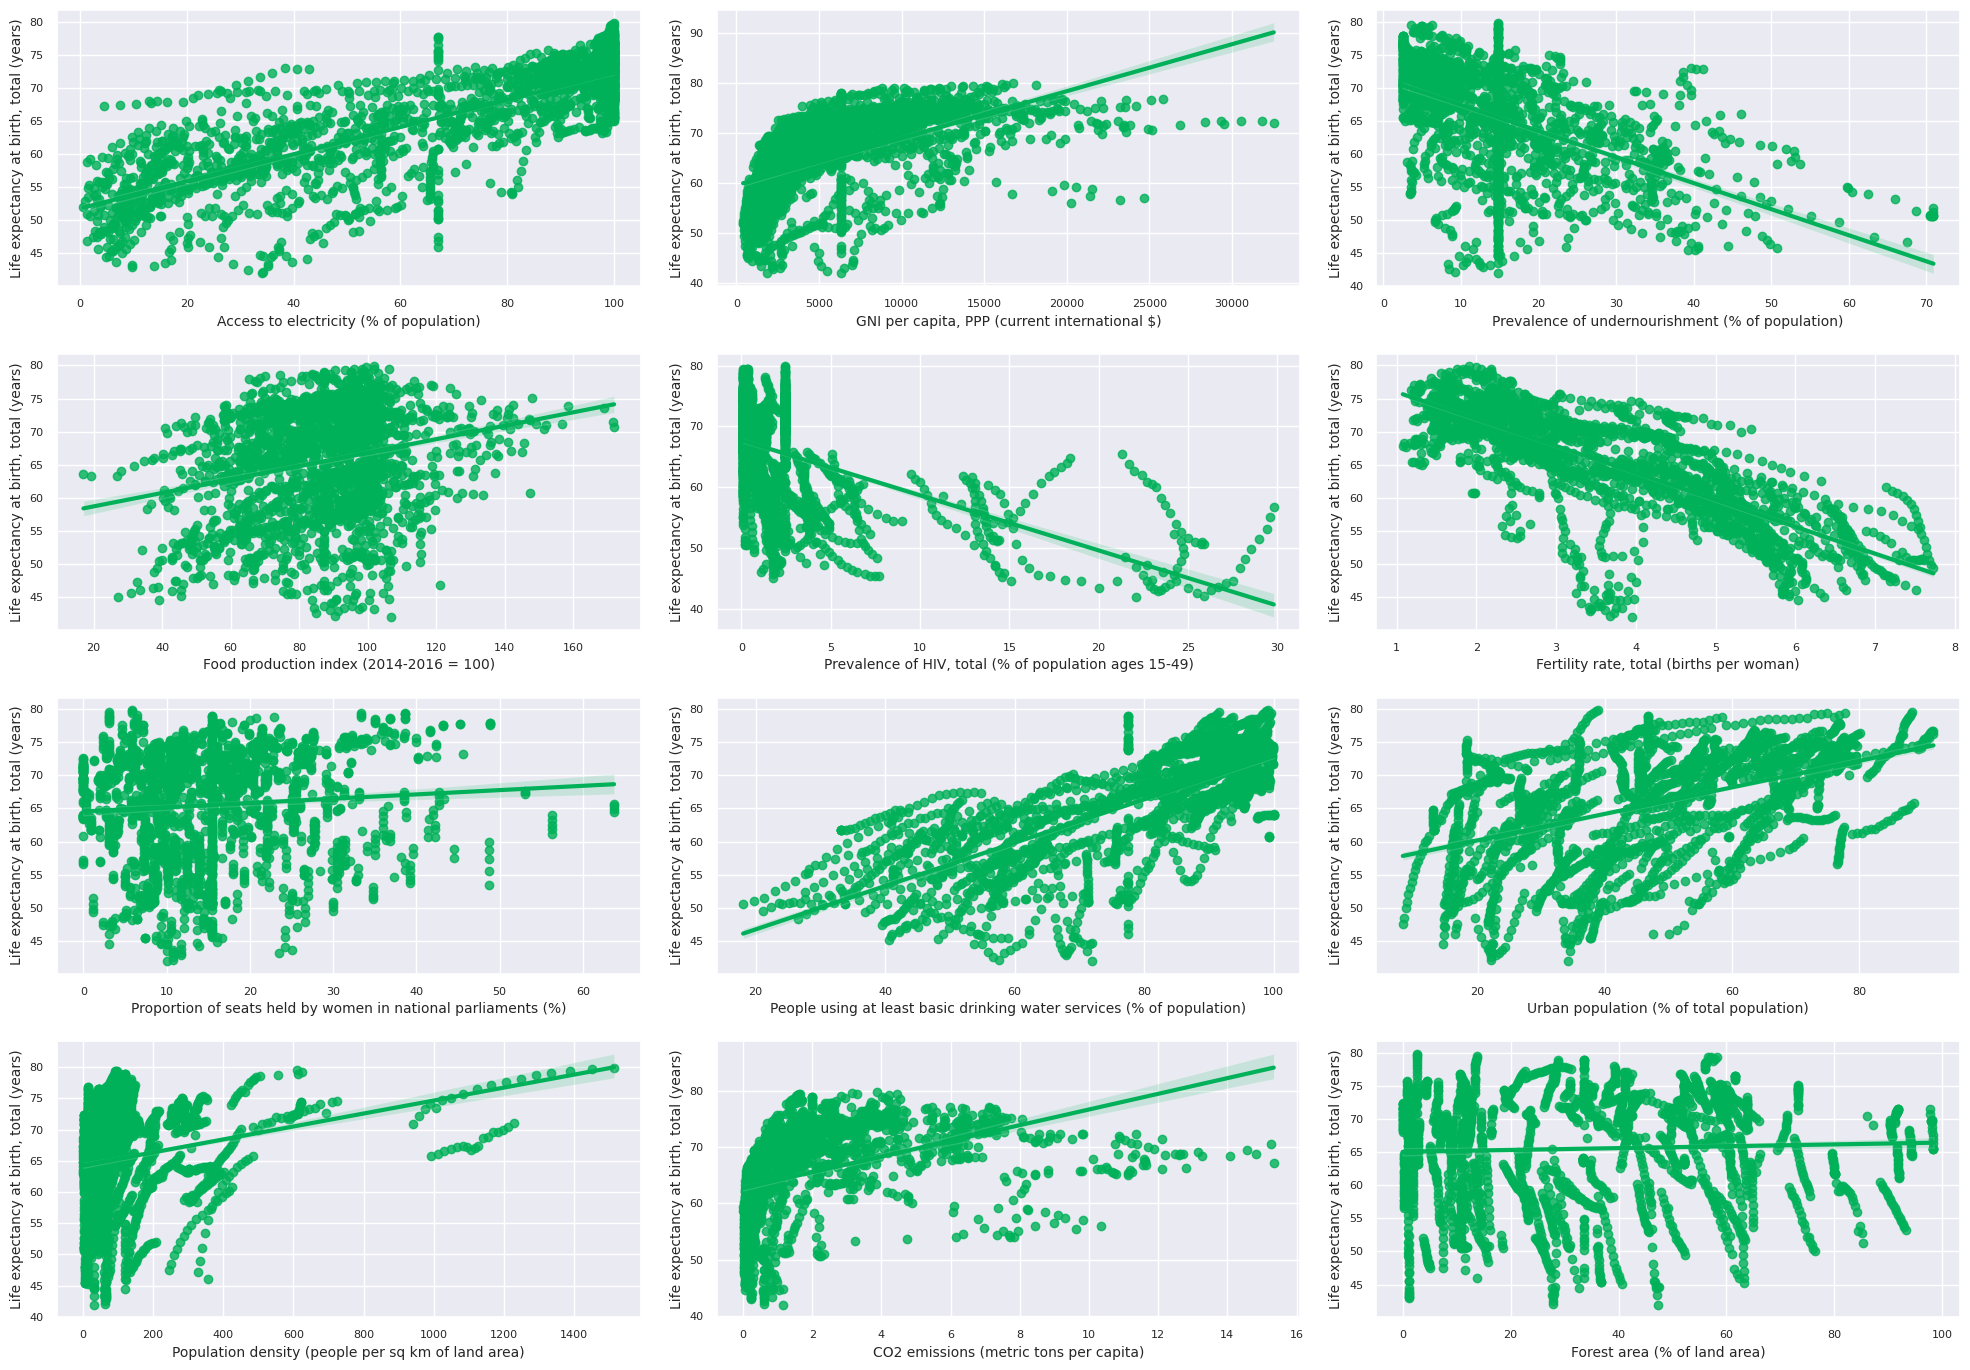

In [ ]:
FEATURES = SDG_pdf.columns
values_to_delete = ["Life expectancy at birth, total (years)"]
FEATURES = [x for x in FEATURES if x not in values_to_delete]

n_rows = 4
n_cols = 3

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20,14))

for i,f in enumerate(FEATURES):
  _ = sns.regplot(data=SDG_pdf,
                  x=f,
                  y="Life expectancy at birth, total (years)",
                  color="#00b159",
                  ax=axes[i//n_cols, i%n_cols])

fig.tight_layout(pad=1.5)

#### **Observations**

The features which show a moderate positive linear relationship with life expectancy include:

- `Access to electricity (% of population)`
- `GNI per capita, PPP (current international $)`
- `Food production index (2014-2016 = 100)`
- `People using at least basic drinking water services (% of population)`
- `Urban population (% of total population)`
- `Population density (people per sq km of land area)`
- `CO2 emissions (metric tons per capita)`

This information makes sense because an increase in basic services, urbanisation and C02 emissions indicates a higher level of country development. Typically countries which have a higher level of development have higher life expectancies due to the decrease in hardship and disease.  

The features which show a moderate negative linear relationship with life expectancy include:

- `Prevalence of undernourishment (% of population)`
- `Prevalence of HIV, total (% of population ages 15-49)`
- `Fertility rate, total (births per woman)`

This information makes sense because an increase in undernourishment or HIV would indicate a less healthy population and thus decreased life expectancies. A higher fertility rate is also indicative of reduced access to contraception, which is prevalent in poorer countries with lower life expectancies

The features which do not show a meangiful relationship with life expectancy include:

- `Proportion of seats held by woman in national parliaments (%)`
- `Forest area (% of land area)`


### **Pearson correlation coefficient and correlation matrix**

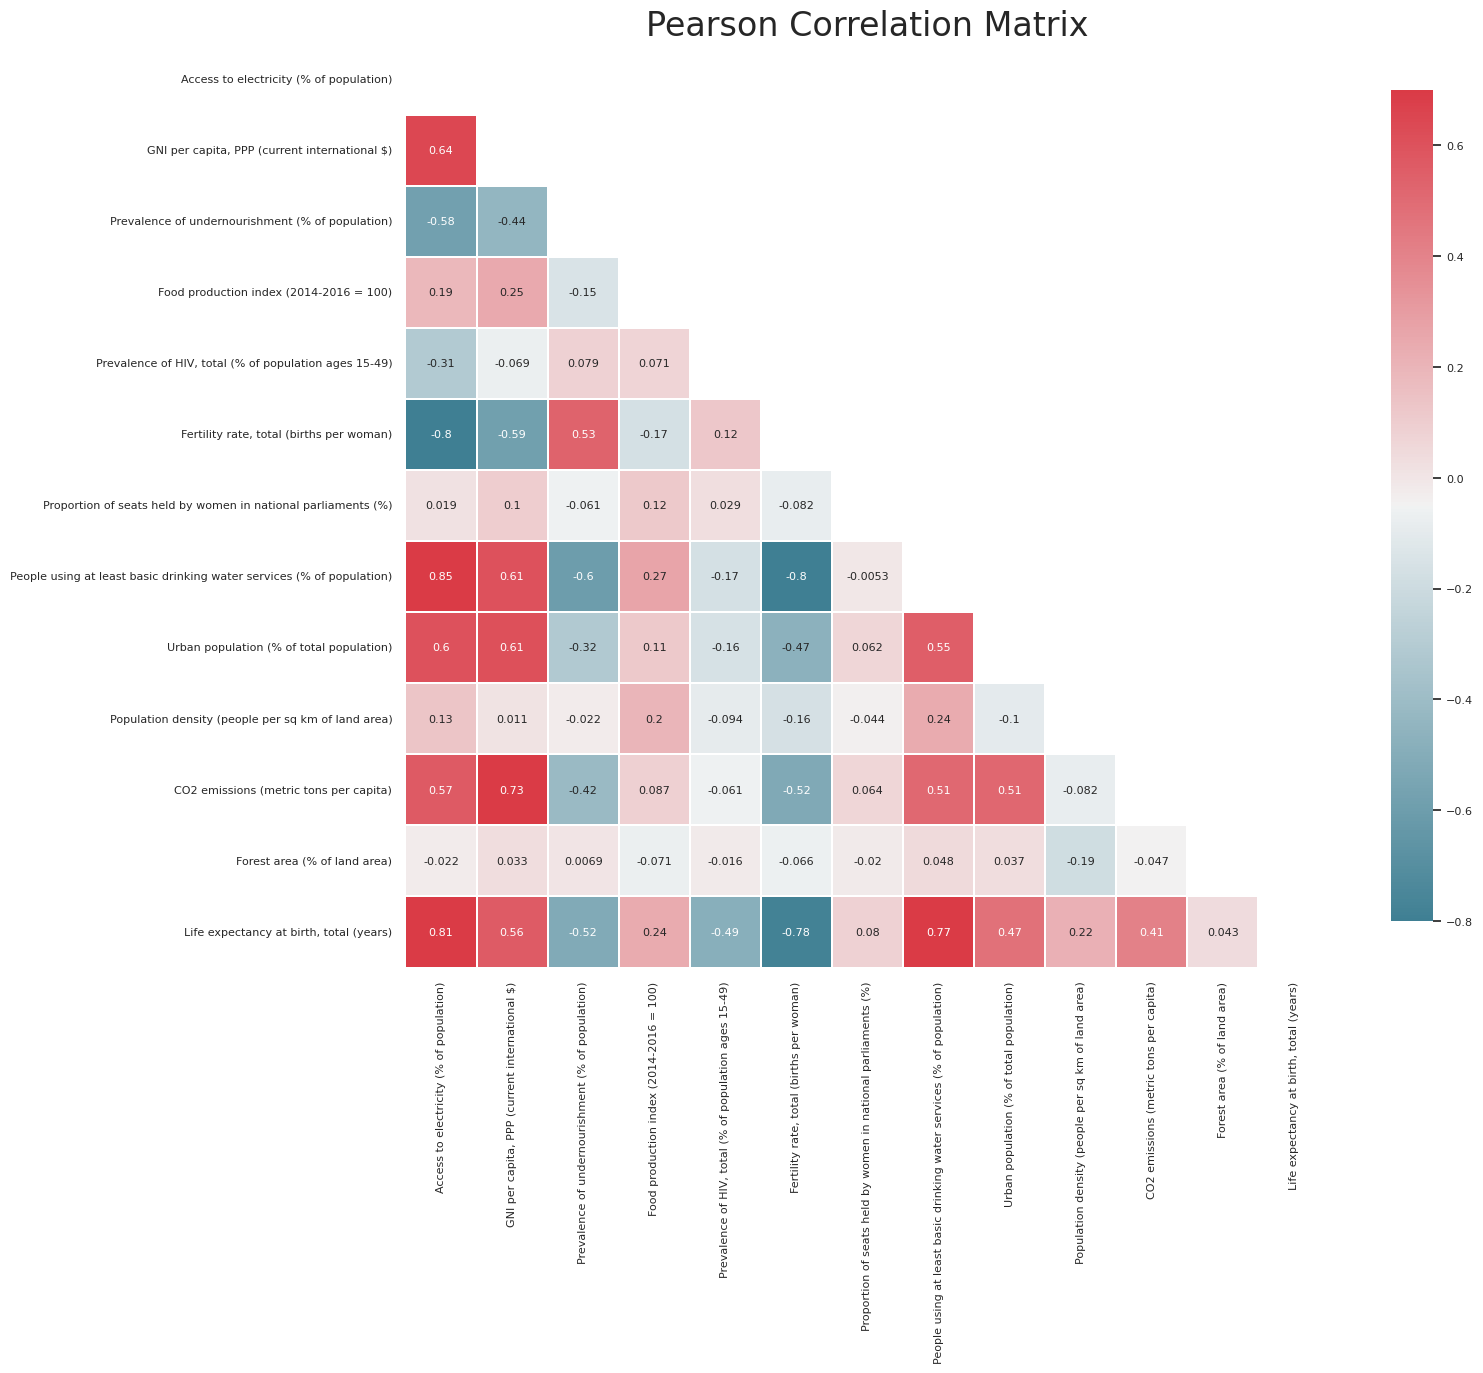

In [ ]:
features = SDG_pdf.columns

mask = np.zeros_like(SDG_pdf[features].corr(), dtype=bool)
mask[np.triu_indices_from(mask)] = True

with sns.axes_style("white"):
  fig, ax = plt.subplots(figsize=(16, 12))
  plt.title('Pearson Correlation Matrix', fontsize=24)

  cmap = sns.diverging_palette(220, 10, as_cmap=True)

  _ = sns.heatmap(SDG_pdf[features].corr(),
              linewidths=0.25,
              vmax=0.7,
              square=True,
              ax=ax,
              cmap=cmap,
              linecolor='w',
              annot=True,
              annot_kws={"size":8},
              mask=mask,
              cbar_kws={"shrink": .9});

#### **Observations**

As observed in the regression plots, there is a very low correlation between `Proportion of seats held by woman in national parliaments (%)` and `Life expectancy at birth, total (years)`, with a regression score of ($\rho = 0.08$).

The correlation between `Forest area (% of land area)` and `Life expectancy at birth, total (years)` is also very low with a regression score of ($\rho = 0.043$)

### **Drop features with low regression scores**

The features which have very low regression scores will be dropped because they do not provide meaningful information regarding the life expectancy.

In [ ]:
columns_to_drop = ['Proportion of seats held by women in national parliaments (%)', 'Forest area (% of land area)']
SDG_df = SDG_df.drop(*columns_to_drop)

# **4. Linear Regression Model**

### **Dataset Splitting: Training vs. Test Set**

In [ ]:
# Randomly split the data
train_df, test_df = SDG_df.randomSplit([0.9, 0.1], seed=RANDOM_SEED)

In [ ]:
# Set the target and feature variables
TARGET_VARIABLE = "Life expectancy at birth, total (years)"
FEATURES = SDG_df.columns
FEATURES.pop();

### **Linear regression pipeline**

In [ ]:
def linear_regression_pipeline(spark, data, features_col, label_col, num_folds=5):

  from pyspark.ml import Pipeline
  from pyspark.ml.feature import VectorAssembler, StandardScaler
  from pyspark.ml.regression import LinearRegression
  from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
  from pyspark.ml.evaluation import RegressionEvaluator

  # Assemble features vector
  assembler = VectorAssembler(inputCols=features_col, outputCol="features")

  # Scale features
  scaler = StandardScaler(inputCol="features", outputCol="scaled_features")

  if label_col != "label":
      data = data.withColumnRenamed(label_col, "label")

  label_col = "label"

  # Create Linear Regression model
  lr = LinearRegression(featuresCol="scaled_features", labelCol=label_col)

  # Create pipeline
  pipeline = Pipeline(stages=[assembler, scaler, lr])

  # Define parameter grid for tuning
  param_grid = ParamGridBuilder() \
      .addGrid(lr.regParam, [0.0, 0.01, 0.1, 1.0]) \
      .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0]) \
      .build()

  # Define evaluator
  evaluator = RegressionEvaluator(metricName="rmse")

  # Create CrossValidator
  crossval = CrossValidator(estimator=pipeline,
                            estimatorParamMaps=param_grid,
                            evaluator=evaluator,
                            numFolds=num_folds,
                            collectSubModels=True)

  # Run cross-validation
  cv_model = crossval.fit(data)


  return cv_model

In [ ]:
linear_regression_model = linear_regression_pipeline(spark, train_df, FEATURES, TARGET_VARIABLE)

### **Summary of trained Linear regression models**

In [ ]:
def model_summary(cv_models):
    for x, models in enumerate(cv_models):
        print("*************** Fold #{:d} ***************\n".format(x+1))
        for i, m in enumerate(models):
            print("--- Model #{:d} out of {:d} ---".format(i+1, len(models)))
            print("\tParameters: lambda=[{:.3f}]; alpha=[{:.3f}] ".format(m.stages[-1]._java_obj.getRegParam(), m.stages[-1]._java_obj.getElasticNetParam()))
            print("\tModel summary: {}\n".format(m.stages[-1]))
        print("***************************************\n")

In [ ]:
model_summary(linear_regression_model.subModels)

*************** Fold #1 ***************

--- Model #1 out of 12 ---
	Parameters: lambda=[0.000]; alpha=[0.000] 
	Model summary: LinearRegressionModel: uid=LinearRegression_5477dab376b4, numFeatures=10

--- Model #2 out of 12 ---
	Parameters: lambda=[0.000]; alpha=[0.500] 
	Model summary: LinearRegressionModel: uid=LinearRegression_5477dab376b4, numFeatures=10

--- Model #3 out of 12 ---
	Parameters: lambda=[0.000]; alpha=[1.000] 
	Model summary: LinearRegressionModel: uid=LinearRegression_5477dab376b4, numFeatures=10

--- Model #4 out of 12 ---
	Parameters: lambda=[0.010]; alpha=[0.000] 
	Model summary: LinearRegressionModel: uid=LinearRegression_5477dab376b4, numFeatures=10

--- Model #5 out of 12 ---
	Parameters: lambda=[0.010]; alpha=[0.500] 
	Model summary: LinearRegressionModel: uid=LinearRegression_5477dab376b4, numFeatures=10

--- Model #6 out of 12 ---
	Parameters: lambda=[0.010]; alpha=[1.000] 
	Model summary: LinearRegressionModel: uid=LinearRegression_5477dab376b4, numFeatur

### **Average RMSE for each K-fold cross validation Linear regression model setting**

In [ ]:
for i, avg_RMSE in enumerate(linear_regression_model.avgMetrics):
    print("Avg. RMSE computed across k-fold cross validation for model setting #{:d}: {:3f}".format(i+1, avg_RMSE))

Avg. RMSE computed across k-fold cross validation for model setting #1: 3.377013
Avg. RMSE computed across k-fold cross validation for model setting #2: 3.377013
Avg. RMSE computed across k-fold cross validation for model setting #3: 3.377013
Avg. RMSE computed across k-fold cross validation for model setting #4: 3.376967
Avg. RMSE computed across k-fold cross validation for model setting #5: 3.377065
Avg. RMSE computed across k-fold cross validation for model setting #6: 3.377244
Avg. RMSE computed across k-fold cross validation for model setting #7: 3.377451
Avg. RMSE computed across k-fold cross validation for model setting #8: 3.382096
Avg. RMSE computed across k-fold cross validation for model setting #9: 3.391917
Avg. RMSE computed across k-fold cross validation for model setting #10: 3.429583
Avg. RMSE computed across k-fold cross validation for model setting #11: 3.625168
Avg. RMSE computed across k-fold cross validation for model setting #12: 3.860051


### **Performance of linear regression model on the training data: $\text{RMSE}$ and $\text{R}^2$ statistic**

In [ ]:
training_result = linear_regression_model.bestModel.stages[-1].summary
print("***** Training Set *****")
print("RMSE: {:.3f}".format(training_result.rootMeanSquaredError))
print("R2: {:.3f}".format(training_result.r2))
print("Adjusted R2: {:.3f}".format(training_result.r2adj))
print("***** Training Set *****")

***** Training Set *****
RMSE: 3.357
R2: 0.835
Adjusted R2: 0.834
***** Training Set *****


### **Predicted life expectancy using the Linear regression model**

In [ ]:
test_df = test_df.withColumnRenamed("Life expectancy at birth, total (years)", "label")
predictions = linear_regression_model.transform(test_df)

In [ ]:
predictions.select("features", "prediction", "label").show(5)

+--------------------+-----------------+------+
|            features|       prediction| label|
+--------------------+-----------------+------+
|[1.5,6354.2314453...|59.73109282817357|54.812|
|[1.89250123500823...|53.14846136678783| 50.66|
|[5.16266441345214...| 57.8605923550057|59.433|
|[5.69999980926513...| 52.4872447796882|50.065|
|[6.90000009536743...|46.83576222638783|50.453|
+--------------------+-----------------+------+
only showing top 5 rows



In [ ]:
def model_evaluation(predictions, metric="rmse"):

    from pyspark.ml.evaluation import RegressionEvaluator

    evaluator = RegressionEvaluator(labelCol="label",
                                    predictionCol="prediction",
                                    metricName=metric)

    return evaluator.evaluate(predictions)

In [ ]:
def adjusted_R2(predictions):

    regression_score = model_evaluation(predictions, metric="r2")
    adjusted_regression_score = (1 - (1 - regression_score) * ((predictions.count() - 1) / (predictions.count() - predictions.select('features').first()[0].size - 1)))

    return adjusted_regression_score

### **Performance of linear regression model on the test data: $\text{RMSE}$ and $\text{R}^2$ statistic**

In [ ]:
print("***** Test Set *****")
print("RMSE: {:.3f}".format(model_evaluation(predictions)))
print("R2: {:.3f}".format(model_evaluation(predictions, metric="r2")))
print("Adjusted R2: {:.3f}".format(adjusted_R2(predictions)))
print("***** Test Set *****")

***** Test Set *****
RMSE: 3.153
R2: 0.845
Adjusted R2: 0.837
***** Test Set *****


# **5. Random Forest Regression Model**

### **Random forest regression pipeline**

In [ ]:
def random_forest_regression_pipeline(spark, data, features_col, label_col, num_folds=5):


    from pyspark.ml import Pipeline
    from pyspark.ml.feature import VectorAssembler, StandardScaler
    from pyspark.ml.regression import RandomForestRegressor
    from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
    from pyspark.ml.evaluation import RegressionEvaluator

    # Assemble features vector
    assembler = VectorAssembler(inputCols=features_col, outputCol="features")

    if label_col != "label":
      data = data.withColumnRenamed(label_col, "label")

    label_col = "label"

    # Create Random Forest Regression model
    rf = RandomForestRegressor(featuresCol="features", labelCol=label_col)

    # Create pipeline
    pipeline = Pipeline(stages=[assembler, rf])

    # Define parameter grid for tuning
    param_grid = ParamGridBuilder() \
        .addGrid(rf.numTrees, [10, 20, 30]) \
        .addGrid(rf.maxDepth, [5, 10, 15]) \
        .build()

    # Define evaluator
    evaluator = RegressionEvaluator(metricName="rmse")

    # Create CrossValidator
    crossval = CrossValidator(estimator=pipeline,
                              estimatorParamMaps=param_grid,
                              evaluator=evaluator,
                              numFolds=num_folds,
                              collectSubModels=True)

    # Run cross-validation
    cv_model = crossval.fit(data)

    return cv_model

In [ ]:
random_forest_model = random_forest_regression_pipeline(spark, train_df, FEATURES, TARGET_VARIABLE)

### **Average RMSE for each K-fold cross validation Random forest regression model setting**

In [ ]:
for i, avg_RMSE in enumerate(random_forest_model.avgMetrics):
    print("Avg. RMSE computed across k-fold cross validation for model setting #{:d}: {:3f}".format(i+1, avg_RMSE))

Avg. RMSE computed across k-fold cross validation for model setting #1: 2.789867
Avg. RMSE computed across k-fold cross validation for model setting #2: 1.695154
Avg. RMSE computed across k-fold cross validation for model setting #3: 1.423246
Avg. RMSE computed across k-fold cross validation for model setting #4: 2.757102
Avg. RMSE computed across k-fold cross validation for model setting #5: 1.586319
Avg. RMSE computed across k-fold cross validation for model setting #6: 1.312485
Avg. RMSE computed across k-fold cross validation for model setting #7: 2.791744
Avg. RMSE computed across k-fold cross validation for model setting #8: 1.573223
Avg. RMSE computed across k-fold cross validation for model setting #9: 1.292943


### **Performance of the Random forest regression model on the training data: $\text{RMSE}$ and $\text{R}^2$ statistic**

In [ ]:
from pyspark.ml.evaluation import RegressionEvaluator

training_result = random_forest_model.bestModel
train_df_new = train_df.withColumnRenamed("Life expectancy at birth, total (years)", "label")
predictions = training_result.transform(train_df_new)

# Evaluate RMSE
evaluator_rmse = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="rmse")
rmse = evaluator_rmse.evaluate(predictions)

# Evaluate R2
evaluator_r2 = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="r2")
r2 = evaluator_r2.evaluate(predictions)

# Calculate R2 adjusted
num_samples = predictions.count()
num_predictors = len(training_result.stages[-1].featureImportances)
r2_adjusted = 1 - ((1 - r2) * (num_samples - 1)) / (num_samples - num_predictors - 1)

print("***** Training Set *****")
print("RMSE: {:.3f}".format(rmse))
print("R2: {:.3f}".format(r2))
print("Adjusted R2: {:.3f}".format(r2_adjusted))
print("***** Training Set *****")

***** Training Set *****
RMSE: 0.500
R2: 0.996
Adjusted R2: 0.996
***** Training Set *****


### **Predicted life expectancy using the Random forest regression model**

In [ ]:
predictions = random_forest_model.transform(test_df)

In [ ]:
predictions.select("features", "prediction", "label").show(5)

+--------------------+------------------+------+
|            features|        prediction| label|
+--------------------+------------------+------+
|[1.5,6354.2314453...| 56.32538509853303|54.812|
|[1.89250123500823...| 52.62345835367839| 50.66|
|[5.16266441345214...| 59.30158816655477|59.433|
|[5.69999980926513...|49.913851462470156|50.065|
|[6.90000009536743...| 49.40583247290717|50.453|
+--------------------+------------------+------+
only showing top 5 rows



### **Performance of the Random forest regression model on the test data: $\text{RMSE}$ and $\text{R}^2$ statistic**

In [ ]:
print("***** Test Set *****")
print("RMSE: {:.3f}".format(model_evaluation(predictions)))
print("R2: {:.3f}".format(model_evaluation(predictions, metric="r2")))
print("Adjusted R2: {:.3f}".format(adjusted_R2(predictions)))
print("***** Test Set *****")

***** Test Set *****
RMSE: 1.085
R2: 0.982
Adjusted R2: 0.981
***** Test Set *****


# **6. Model Parameter Analysis**

### **Linear Regression Model Parameters**

In [ ]:
intercept = linear_regression_model.bestModel.stages[-1].intercept
coefficients = linear_regression_model.bestModel.stages[-1].coefficients

print("Intercept of the Linear Regression Model:")
print("Intercept: " + str(intercept))
print("*********************************************")
print("Coeffcients of the Linear Regression Model:")

for x in range(10):
  print(str(FEATURES[x]) + ": " + str(coefficients[x]))

Intercept of the Linear Regression Model:
Intercept: 64.70011834791835
*********************************************
Coeffcients of the Linear Regression Model:
Access to electricity (% of population): 1.56911058159838
GNI per capita, PPP (current international $): 1.261772306651751
Prevalence of undernourishment (% of population): -0.48402940271041445
Food production index (2014-2016 = 100): 0.7619063547977056
Prevalence of HIV, total (% of population ages 15-49): -2.968841832153205
Fertility rate, total (births per woman): -3.5585388112516405
People using at least basic drinking water services (% of population): 1.008020700215819
Urban population (% of total population): -0.13694109225268575
Population density (people per sq km of land area): 0.17829979572107776
CO2 emissions (metric tons per capita): -1.1737792413613637


#### **Observations**

When analysing the linear regression model, the intercept and coefficients are the two important parameters.

The intercept represents the bias term and is the value that would be predicted in the absence of any other feature information. For the linear regression model trained in this assignment, the intercept is 64.7 years.

The coefficients represent the weightings of the different features used in the linear regression model and the higher the magnitude, the more important the feature is in predicting the life expectancy.

The features with the highest significance ($Magnitude > 2$) in the prediction of life expectancy are:

- `Fertility rate, total (births per woman)`
- `Prevalence of HIV, total (% of population ages 15-49)`

The features with moderate significance ($1 < Magnitude < 2$) in the prediction of life expectancy are:

- `Access to electricity (% of population)`
- `GNI per capita, PPP (current international $)`
- `People using at least basic drinking water services (% of population)`
- `CO2 emissions (metric tons per capita)`

The features with the lowest significance ($0 < Magnitude < 1$) in the prediction of life expectancy are:

- `Food production index (2014-2016 = 100)`
- `Prevalence of undernourishment (% of population)`
- `Urban population (% of total population)`
- `Population density (people per sq km of land area)`


### **Random Forest Regression Model Parameters**

In [ ]:
estimators = random_forest_model.bestModel.stages[-1].getNumTrees
feature_importances = random_forest_model.bestModel.stages[-1].featureImportances

print("Number of Estimators of the Random Forest Regression Model:")
print("Estimators: " + str(estimators))
print("*********************************************")
print("Feature importances of the Random Forest Regression Model:")

for x in range(10):
  print(str(FEATURES[x]) + ": " + str(feature_importances[x]))


Number of Estimators of the Random Forest Regression Model:
Estimators: 30
*********************************************
Feature importances of the Random Forest Regression Model:
Access to electricity (% of population): 0.28858164932055336
GNI per capita, PPP (current international $): 0.03468691588816594
Prevalence of undernourishment (% of population): 0.014853789157994105
Food production index (2014-2016 = 100): 0.014953005985283766
Prevalence of HIV, total (% of population ages 15-49): 0.11177787496964493
Fertility rate, total (births per woman): 0.16058835225080706
People using at least basic drinking water services (% of population): 0.2711816543927942
Urban population (% of total population): 0.0292136199386437
Population density (people per sq km of land area): 0.030925125353187862
CO2 emissions (metric tons per capita): 0.04323801274292514


#### **Observations**

When analysing the random forest regression model, the most important parameter is the feature importances. Each feature used in the model is assigned a percentage, in which a higher percentage indicates a higher importance in predicting the life expectancy of an individual.

The most important features (% > 0.1) for predicting life expectancy are:

- `Access to electricity (% of population)`
- `Fertility rate, total (births per woman)`
- `People using at least basic drinking water services (% of population)`
- `CO2 emissions (metric tons per capita)`

The features which are less important (% < 0.1) in the prediction of life expectancy are:

- `GNI per capita, PPP (current international $)`
- `Prevalence of undernourishment (% of population)`
- `Food production index (2014-2016 = 100)`
- `Prevalence of HIV, total (% of population ages 15-49)`
- `Urban population (% of total population)`
- `Population density (people per sq km of land area)`



# **7. Conclusion**

18 Different SDGs were analysed in an attempt to use them to predict life expectancy in low, low-middle, and upper-middle-income countries. Of the 18 SDGs, only ten were used to train the models due to a large amount of missing data or features providing little meaningful information concerning life expectancy.

A linear regression model and a random forest regression model were trained using the final 10 SDGs to predict life expectancy. The linear regression model had an RMSE of 3.36 years and 3.15 years and a regression score of 0.835 and 0.845 for the training and test data, respectively. The linear regression model performed better on the test data than the training data, indicating that the model can generalize to unseen data and is not overfitting to the training data. The random forest regression model had an RMSE of 0.545 years and 1.154 years and a regression score of 0.996 and 0.979 for the training and test data, respectively. The random forest regression model performed better on the training data than the test data, which indicates overfitting to the training data and, thus, a lack of generalization. Even though the random forest regression model displayed slight overfitting, it outperformed the linear regression model and, thus, is the optimal model in this assignment.

The limitations of the linear regression model include its inability to handle multicollinearity within the dataset and its high sensitivity to outliers affecting the accuracy of the predictions. Linear regression models also assume a linear relationship exists between the features and the target variable; however, many features do not display a linear relationship. The strengths of the linear regression model include its simplicity and easy interpretability.

The limitation of the random forest regression model is its susceptibility to overfit the training data. This is especially common when the number of decision trees is too high. The strengths of the random forest regression model include its high predictive capability, ability to ignore outliers, and ability to handle non-linear relationships between variables present within this dataset.

The improvements that could be made to improve the overall performance is introducing a function to analyse and remove outliers within the data. Removing outliers would allow for the linear regression model to perform better. The random forest model should also be analysed to determine the cause of its overfitting and thus allow for it to perform better when presented with unseen data.